<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Линейная регрессия</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоги" data-toc-modified-id="Итоги-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоги</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем библиотеки и модули, которые потребуются для выполнения проекта

In [1]:
import time
import warnings
import random
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

Загрузим и изучим данные. Выведем на экран первые пять строк и информацию о датасете.

In [2]:
try:
    data = pd.read_csv('datasets/taxi.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Изменим тип данных столбца `'datetime'` с `object` на `datetime64`. Также установим индекс таблицы равным столбцу `'datetime'`.

In [5]:
data['datetime'] = data['datetime'].apply(pd.to_datetime)
data = data.set_index(['datetime'])

*Примечание.* Также можно при загрузке датасета добавить аргументы `index_col=[0]`, `parse_dates=[0]`. Мы выбрали вариант кода, который позволяет сначала посмотреть исходный вид датасета при условии последовательного запуска ячеек.

Выведем первые строки датесета и информацию после изменений.

In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Датасет содержит 26496 записей, интервал между значениями временного ряда составляет 10 минут. Выполним ресемплирование по одному часу. В качестве агрегированного значения возьмем сумму.

In [8]:
data = data.resample('1H').sum()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Теперь датасет содержит 4416 строк.

Проверим данные на наличие пропусков.

In [10]:
data.isna().sum()

num_orders    0
dtype: int64

Пропуски отсутствуют.

Проверим, в хронологическом ли порядке расположены даты и время.

In [11]:
data.index.is_monotonic

True

Даты и время расположены в хронологическом порядке. Сортировка не требуется.

На следующем шаге выполним анализ временного ряда.

**Выводы по шагу 1**

1. Данные загружены.
2. Формат столбца `'datetime'` изменен с `object` на ` datetime64`. Индекс таблицы установлен равным столбцу `'datetime'`.
3. Выполнено ресемплирование по одному часу.
4. Проверено, что даты и время следуют в хронологическом порядке.

## Анализ

Построим график временного ряда.

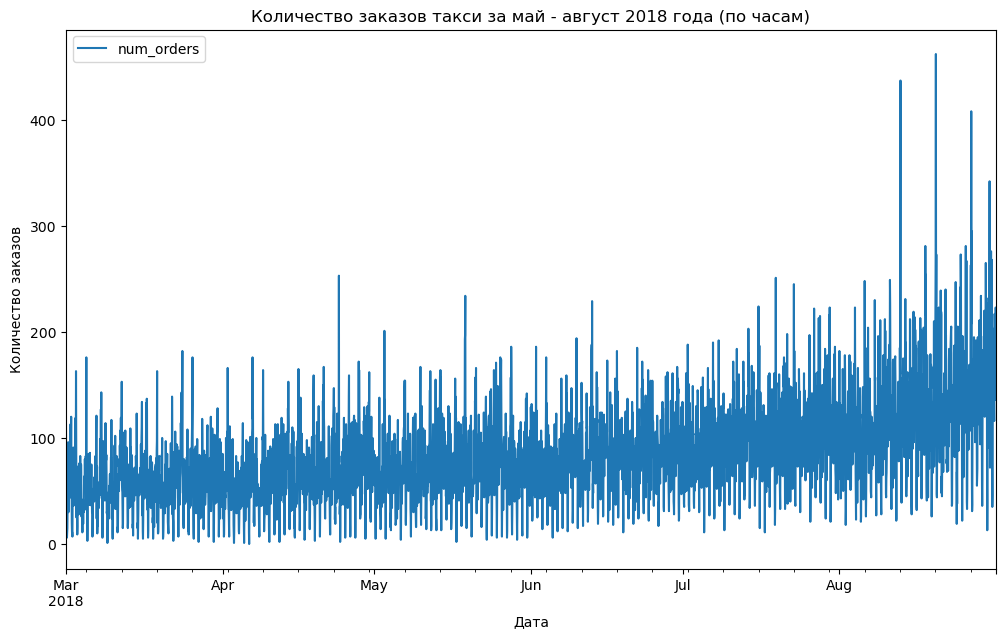

In [12]:
data.plot(figsize=(12,7),
         xlabel="Дата",
         ylabel="Количество заказов",
         title="Количество заказов такси за май - август 2018 года (по часам)");

Пока мало что понятно. Есть пиковые значения и спады, в целом можно отметить постепенное возрастание количества заказов такси в час на интервале в полгода. 

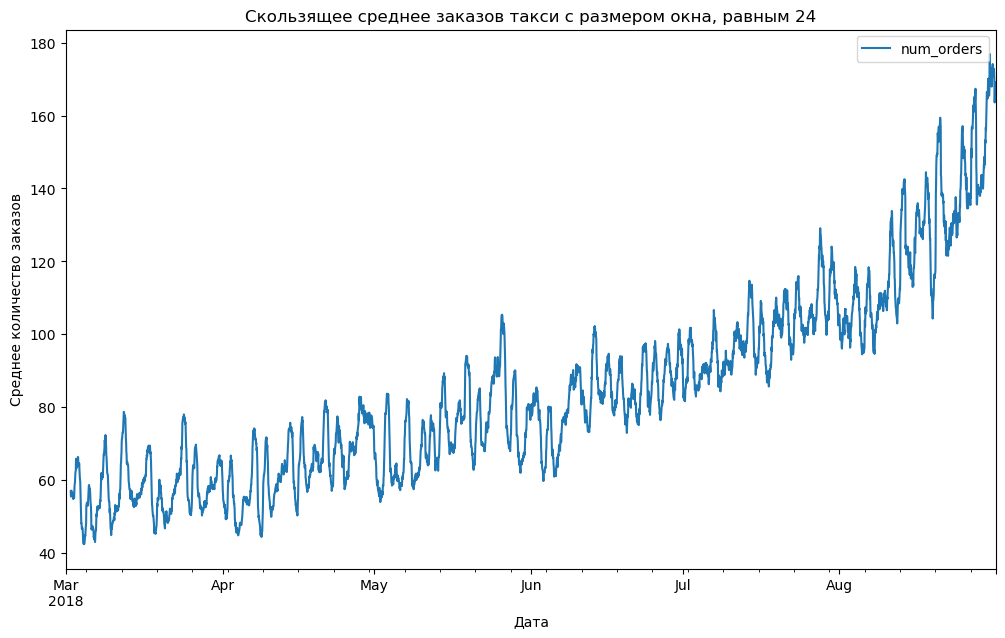

In [13]:
data.rolling(24).mean().plot(figsize=(12, 7),
                            xlabel="Дата",
                            ylabel="Среднее количество заказов", 
                            title="Скользящее среднее заказов такси с размером окна, равным 24");

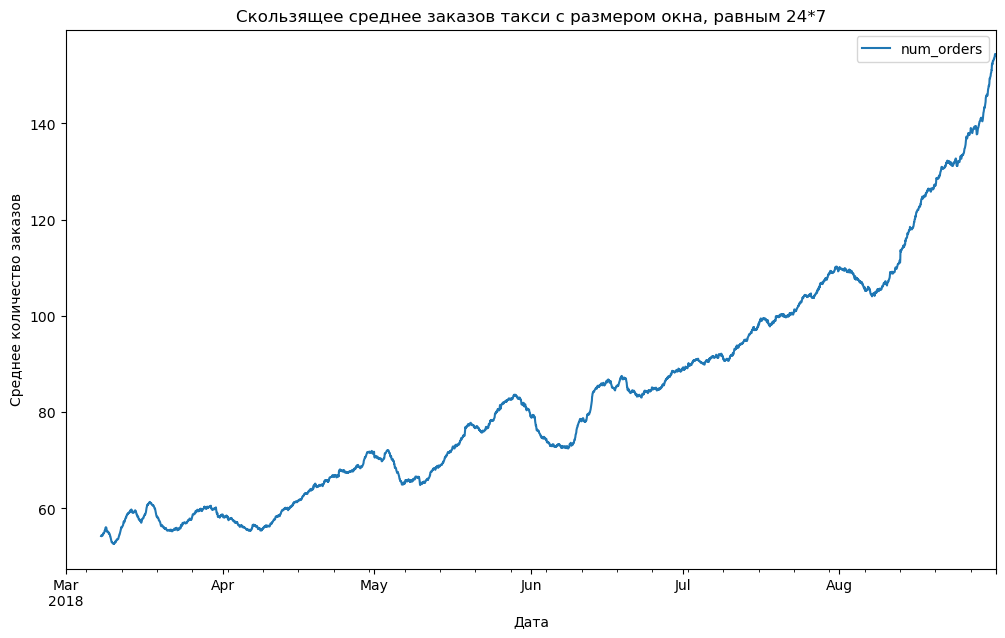

In [14]:
data.rolling(24*7).mean().plot(figsize=(12, 7),
                            xlabel="Дата",
                            ylabel="Среднее количество заказов", 
                            title="Скользящее среднее заказов такси с размером окна, равным 24*7");

Более подробный анализ проведем путем разложения на составляющие.

Разложим временной ряд на тренд и сезонную компоненту. Напишем код для вывода графиков этих составляющих ряда.

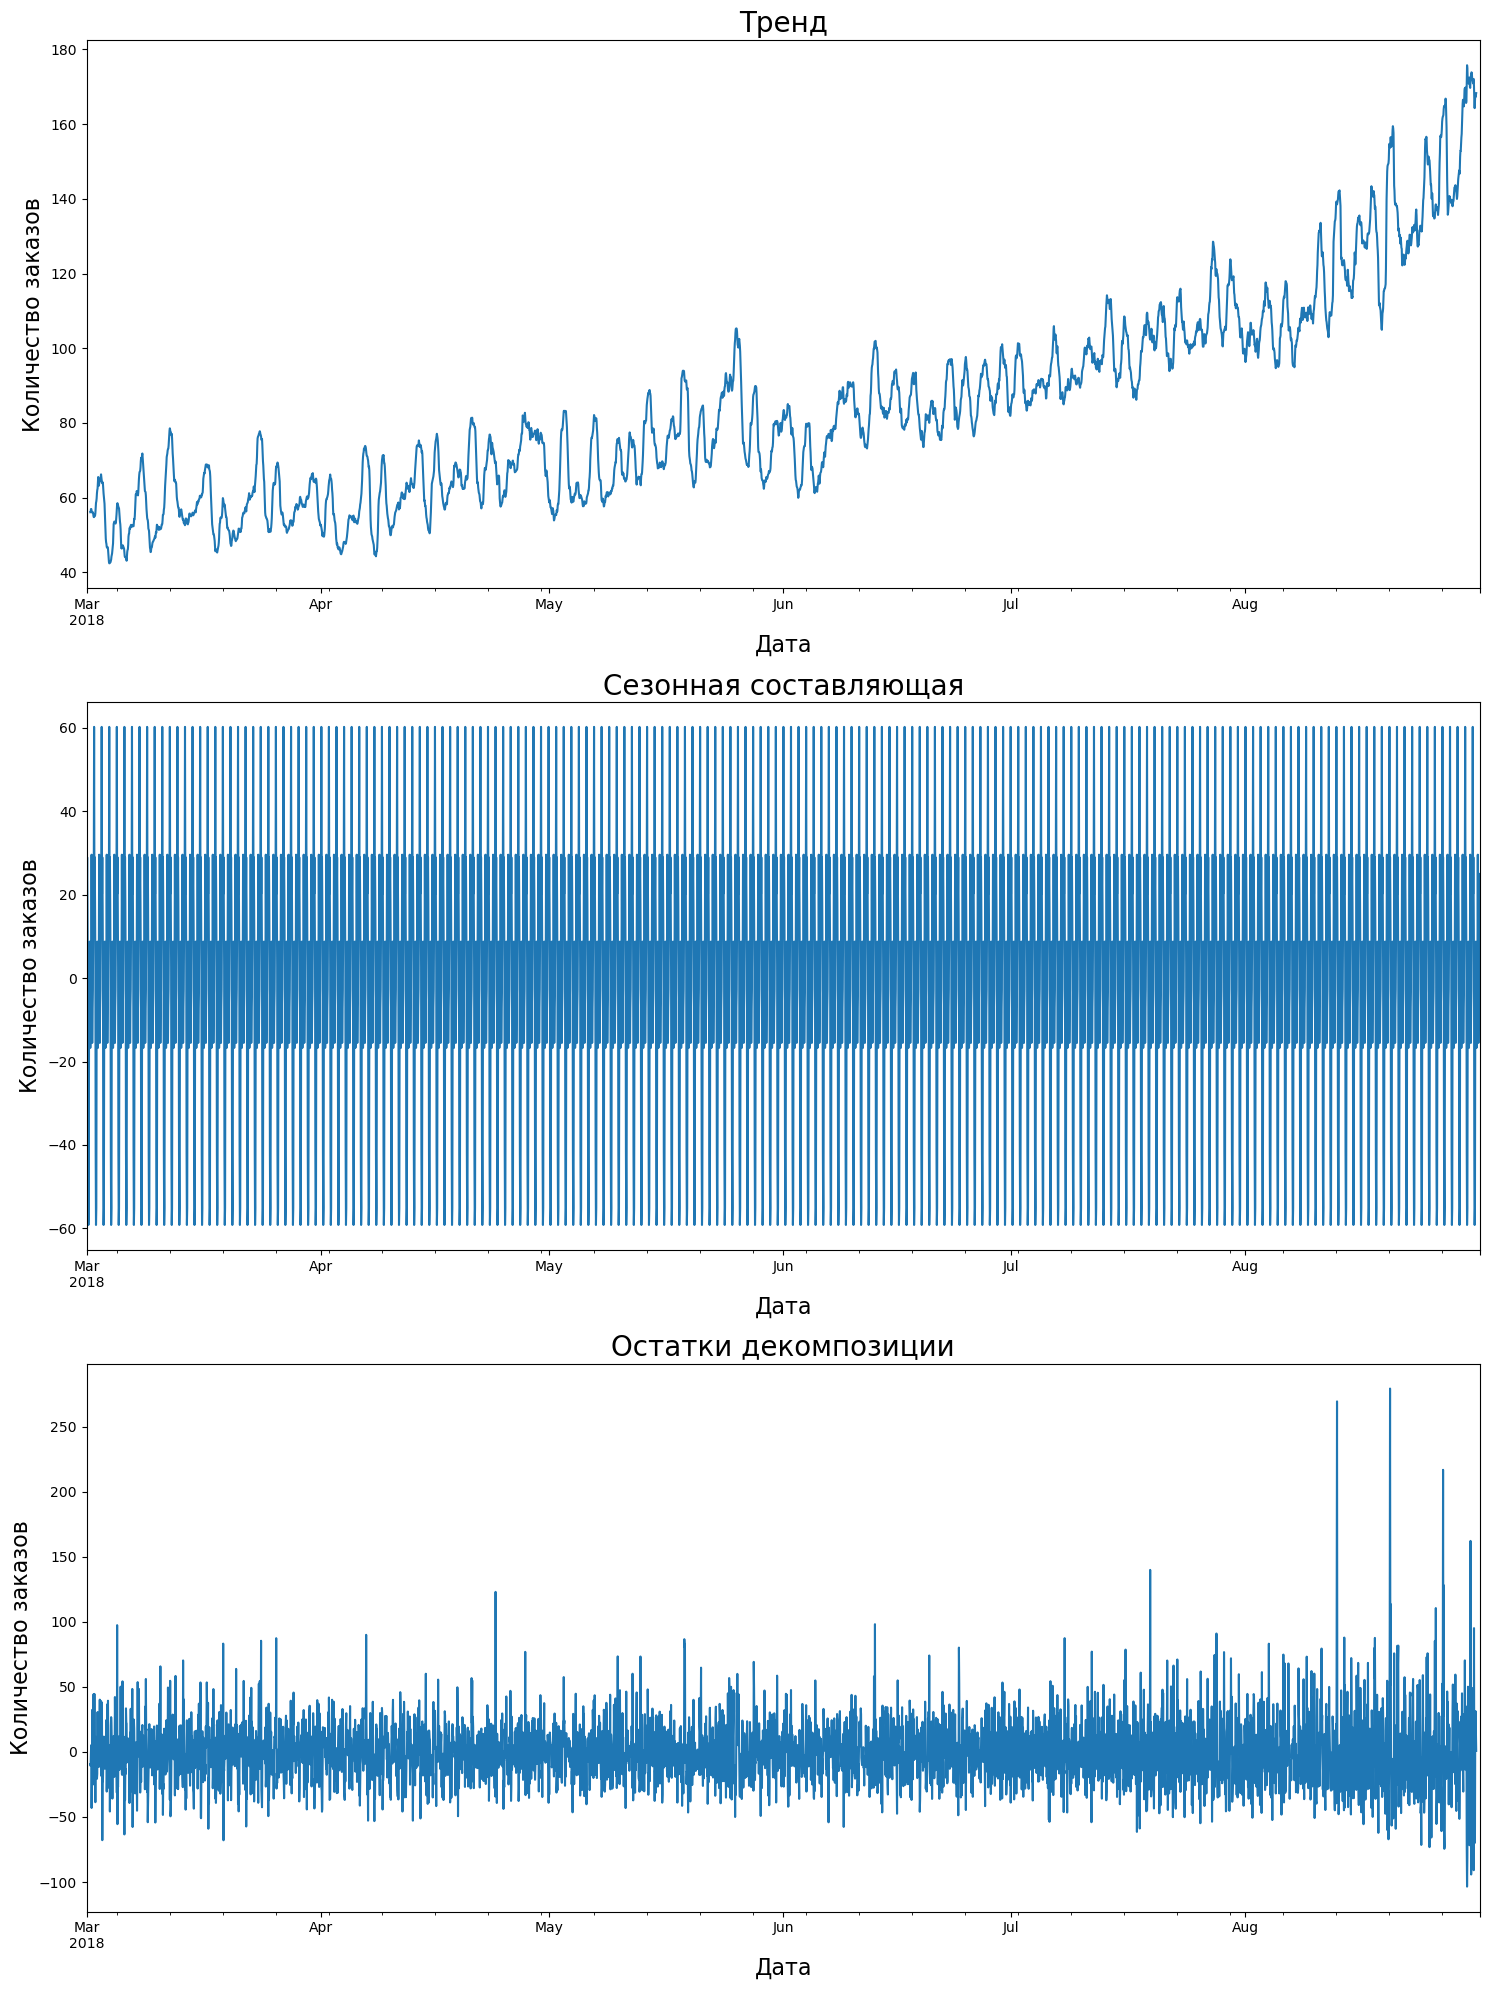

In [15]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(15, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд', fontsize=20)
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Количество заказов', fontsize=16)
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная составляющая', fontsize=20)
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Количество заказов', fontsize=16)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки декомпозиции', fontsize=20)
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Количество заказов', fontsize=16)
plt.tight_layout()

Тренд показывает увеличение количества заказов с марта по август (график очень похож на график скользящего среднего с размером окна 24). Можно предположить, что сезонность связана с периодом в одни сутки (будем проверять это дальше). Остатки необъяснимы.

Построим графики сезонной составляющей за разные промежутки времени (месяц, неделя, 3 дня, сутки).

Cезонность за последний месяц.

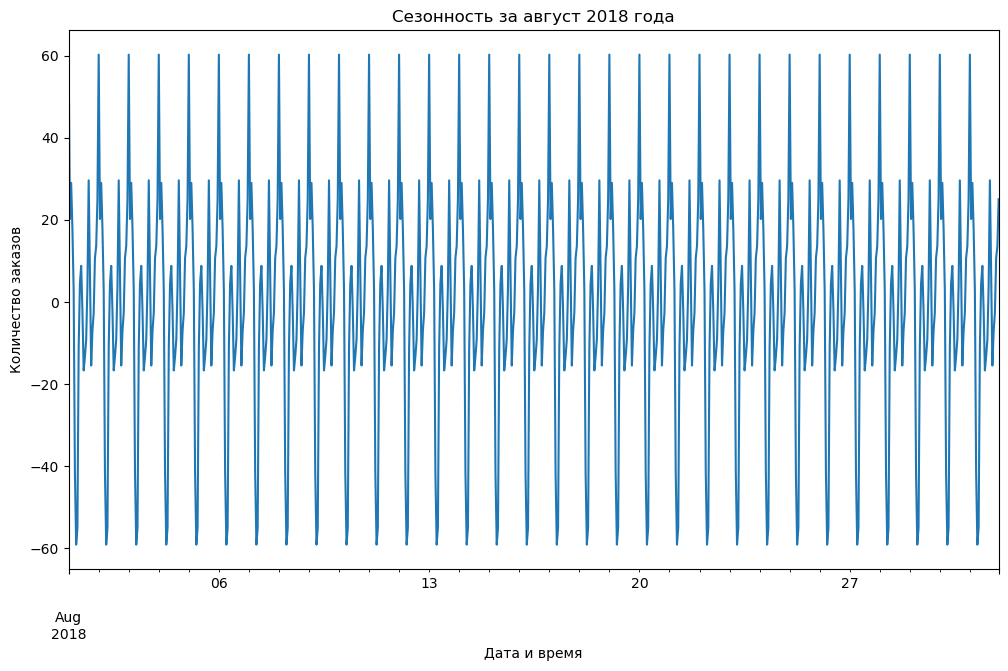

In [16]:
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(figsize=(12, 7),
                                                   title="Сезонность за август 2018 года", 
                                                   xlabel='Дата и время',
                                                   ylabel='Количество заказов');

Cезонность за последнюю неделю.

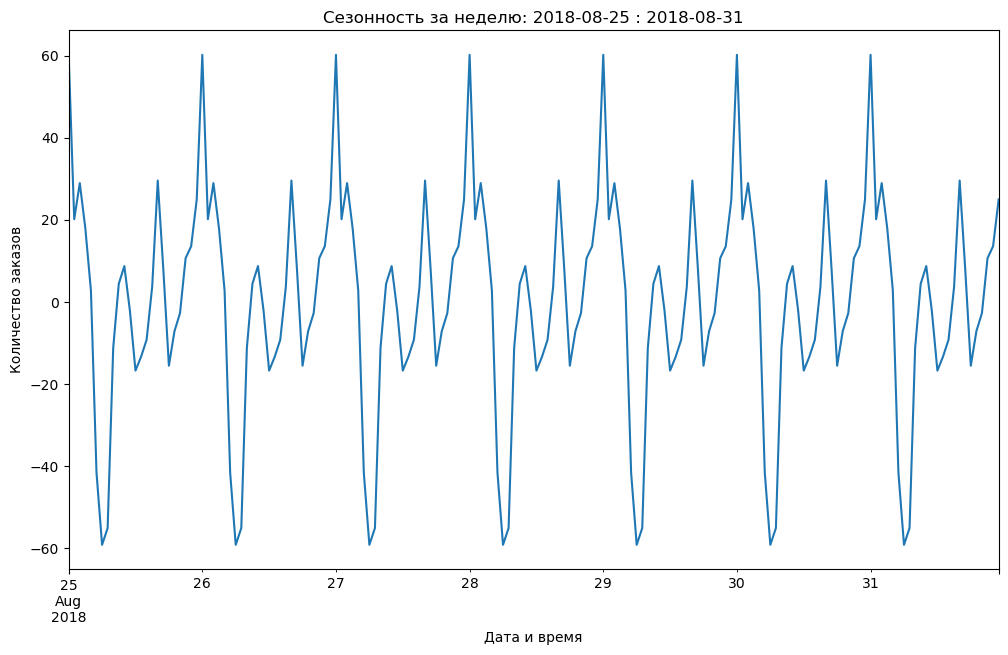

In [17]:
decomposed.seasonal['2018-08-25':'2018-08-31'].plot(figsize=(12, 7), 
                                                    title="Сезонность за неделю: 2018-08-25 : 2018-08-31",
                                                    xlabel='Дата и время',
                                                    ylabel='Количество заказов');

Cезонность за последние 3 дня.

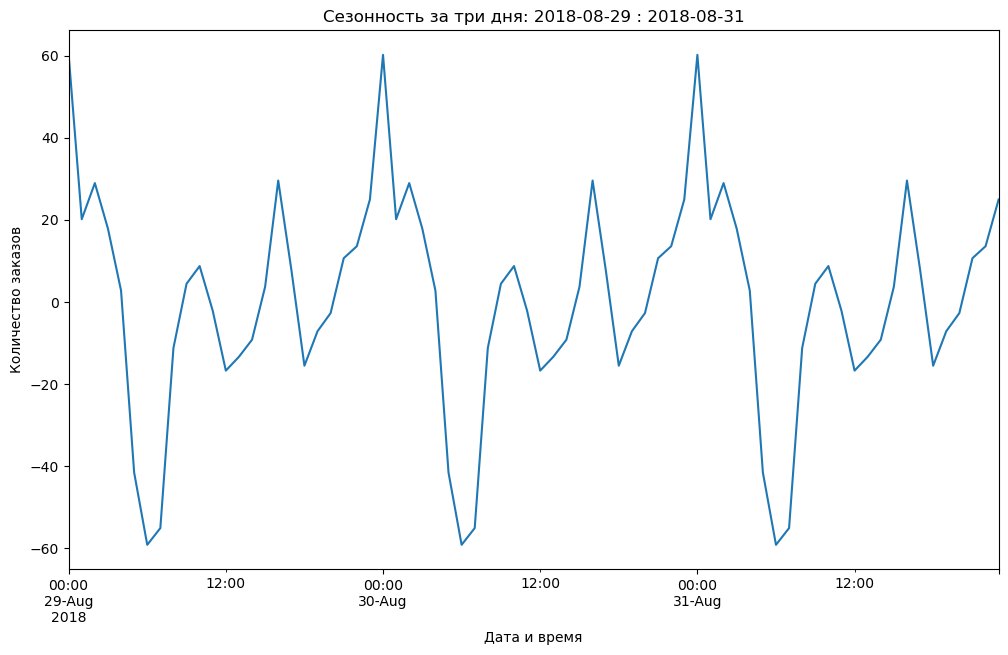

In [18]:
decomposed.seasonal['2018-08-29':'2018-08-31'].plot(figsize=(12, 7),
                                                   title="Сезонность за три дня: 2018-08-29 : 2018-08-31",
                                                   xlabel='Дата и время',
                                                   ylabel='Количество заказов');

Cезонность за последние сутки.

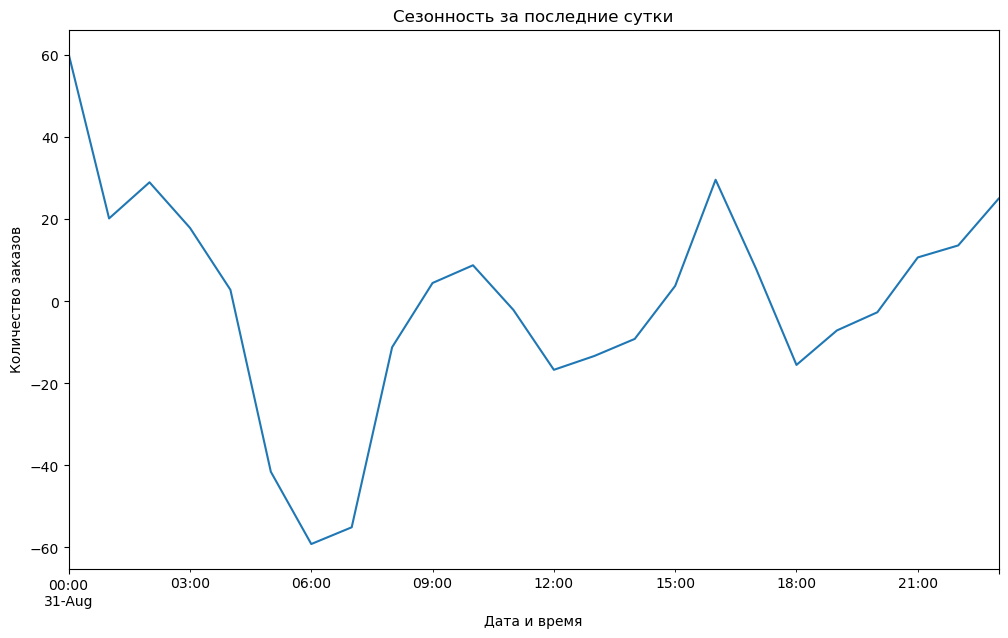

In [19]:
decomposed.seasonal['2018-08-31': '2018-08-31'].plot(figsize=(12, 7),
                                                   title="Сезонность за последние сутки",
                                                    xlabel='Дата и время',
                                                    ylabel='Количество заказов');

Рассмотрение сезонности на разных временных интервалах подтверждает связь с суточным циклом, а также показывает пиковое количество заказов около полуночи, наименьшее количество заказов около 6 часов утра и их увеличение в течение дня.

Связь сезонности именно с периодом в одни сутки можно проверить, выведя график для случайной даты. 

In [20]:
random_date = data.index.date[random.randint(0, 4415)] 

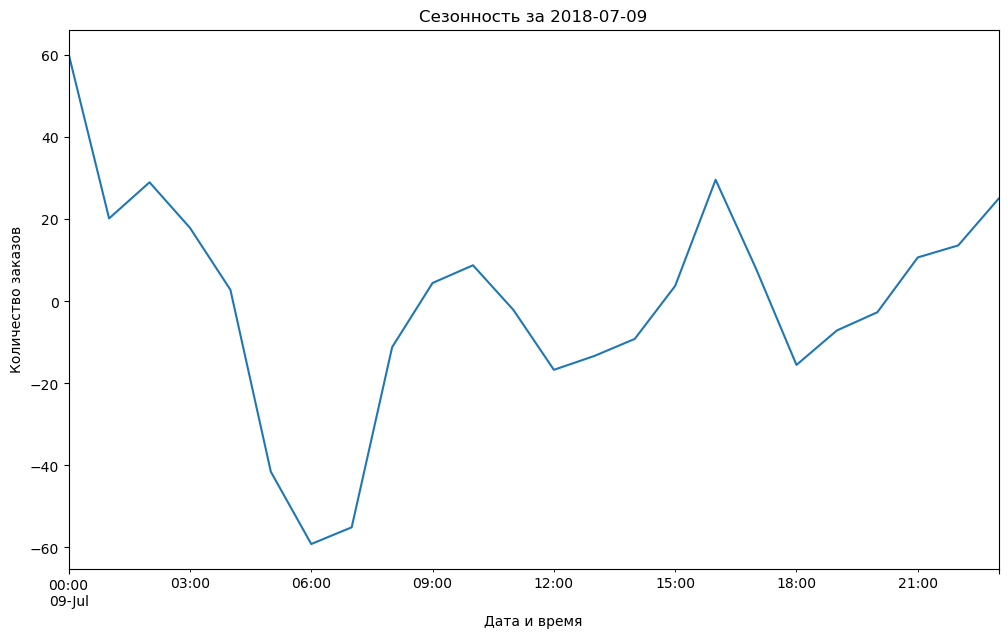

In [21]:
decomposed.seasonal[f"{random_date}" : f"{random_date}"].plot(figsize=(12, 7),
                                                             title=f"Сезонность за {random_date}",
                                                             xlabel='Дата и время',
                                                             ylabel='Количество заказов');

In [22]:
random_date_1 = data.index.date[random.randint(0, 4415)] 

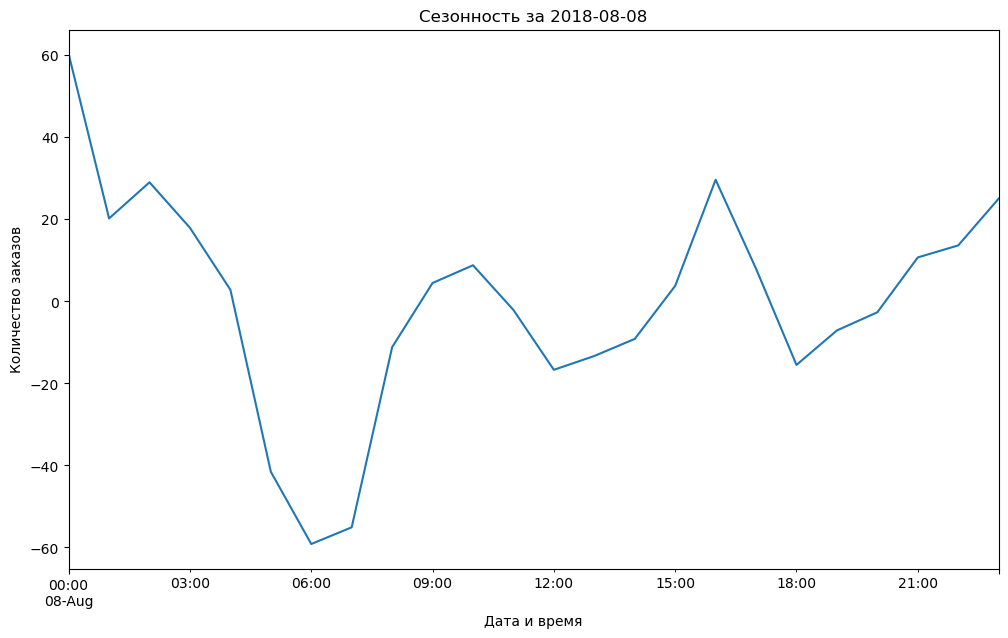

In [23]:
decomposed.seasonal[f"{random_date_1}" : f"{random_date_1}"].plot(figsize=(12, 7),
                                                                 title=f"Сезонность за {random_date_1}",
                                                                 xlabel='Дата и время',
                                                                 ylabel='Количество заказов');

График сезонной составляющей для двух случайных дней в пределах имеющихся данных подтверждает связь сезонности с периодом в одни сутки. Можно объяснить данную природу сезонности тем, что мы рассматриваем данные о заказах в аэропортах: 
* во-первых, суточные колебания можно связать с расписанием прибытия рейсов, которое также связано с суточным циклом (для подтверждения требуется дополнительный анализ расписаний рейсов в аэропортах, в частности, количество рейсов на каждый час, но, похоже, около полуночи действительно много рейсов, см. напр. табло аэропорта Пулково: https://t.rasp.yandex.ru/station/9600366/?event=arrival&time=all), 
* во-вторых, с работой общественного транспорта (около полуночи у пассажиров нет альтернативы такси, около 6 часов, как правило начинает работать транспорт, многие пассажиры, прибывшие около 4-5 часов утра будут ждать именно его, что вызовет уменьшение количества заказов такси в это время).

* **Стационарность временного ряда**

В теории по теме "Временные ряды" затрагивается вопрос о стационарности временных рядов, в частности, о том, что стационарные прогнозировать легче, чем нестационарные. Перед тем, как приступить к обучению, попробуем проверить рассматриваемый временной ряд на стационарность. Сделаем это двумя способами. 

    
   * Сглаживание скользящим средним.

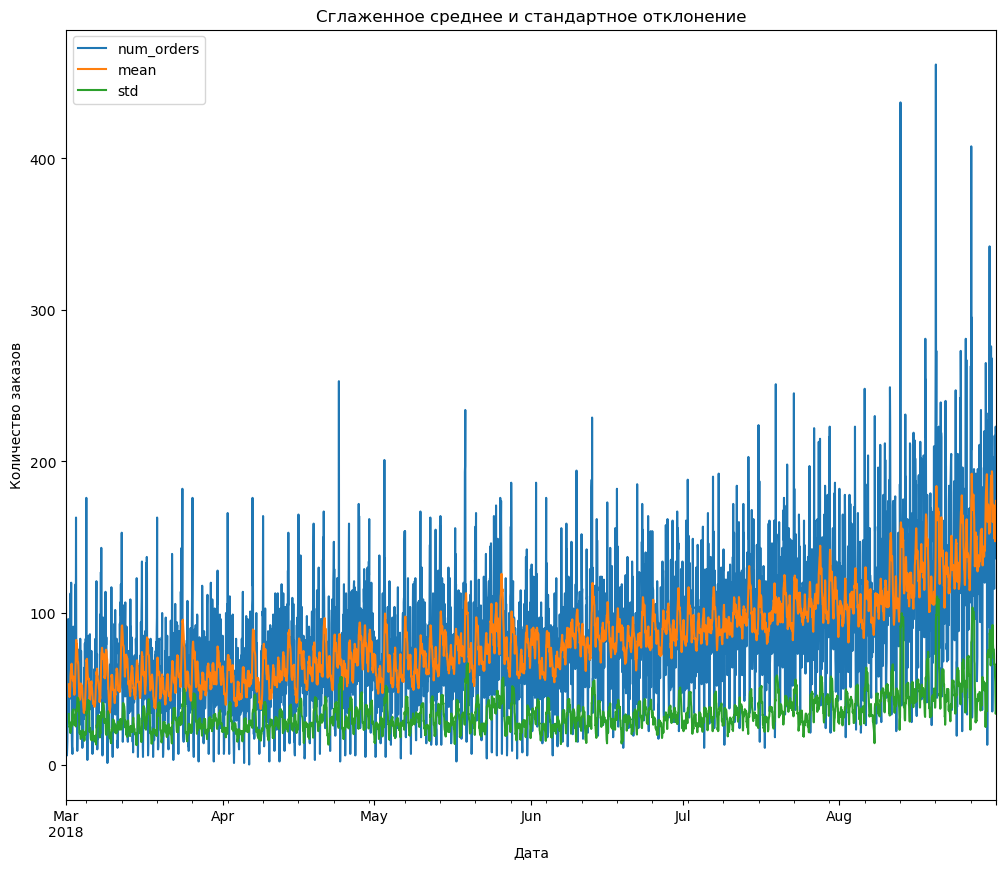

In [24]:
data_rolling = data.copy()
data_rolling['mean'] = data_rolling['num_orders'].rolling(15).mean()
data_rolling['std'] = data_rolling['num_orders'].rolling(15).std()
data_rolling.plot(figsize=(12,10),
                      xlabel='Дата',
                      ylabel='Количество заказов',
                      title='Сглаженное среднее и стандартное отклонение');

График показывает постепенное увеличение значения скользящего среднего на графике. В то же время стандартное отклонение, на основании значения которого можно судить о стационарности ряда (см. теорию к теме "Временные ряды" в тренажере), практически не меняется. Поскольку стационарность, – по всей видимости, градуальное понятие (ряд может быть более или менее стационарным), а среднее меняется постепенно, можно сделать вывод, что ряд нестационарен в строгом смысле, но обладает некоторыми признаками стационарности.

   * Анализ при помощи теста Дики-Фуллера.

 Для этого используем тест Дики-Фуллера (https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html).

    H0: Временной ряд является нестационарным.
    H1: Временной ряд является стационарным.

Пороговое значение p-value = 0.05

In [25]:
pvalue = adfuller(data)[1]
print('p-value:', pvalue)
if pvalue < .05:
    print('Нулевая гипотеза отвергается. Временной ряд является стационарным')
else:
    print('Нулевая гипотеза не отвергается. Временной ряд является нестационарным')

p-value: 0.02894005140261326
Нулевая гипотеза отвергается. Временной ряд является стационарным


Пороговое значение p-value = 0.01

In [26]:
pvalue = adfuller(data)[1]
print('p-value:', pvalue)
if pvalue < .01:
    print('Нулевая гипотеза отвергается. Временной ряд является стационарным')
else:
    print('Нулевая гипотеза не отвергается. Временной ряд является нестационарным')

p-value: 0.02894005140261326
Нулевая гипотеза не отвергается. Временной ряд является нестационарным


Проверка на стационарность разными способами дает неоднозначный результат. В зависимости от строгости критерия ряд можно считать нестационарным или демонстрирующим признаки стационарности ("слабую" стационарность), которых может быть достаточно для прогнозирования.

**Выводы по шагу 2**

Был проведен анализ временного ряда:
1. Графики скользящего среднего и тренда показывают, что в среднем количество заказов такси с марта по август увеличилось.
2. График сезонности показывает связь с интервалом в одни сутки. При этом наибольшее число заказов приходится на время около полуночи, меньше всего - около 6 часов утра. Природа сезонности может быть связана с расписанием рейсов и работой общественного транспорта.
3. Временной ряд не является стационарным в строгом смысле, но демонстрирует признаки стационарности ("слабую" стационарность), которых может быть достаточно для прогнозирования.

## Обучение

Создадим функцию для создания признаков. Создадим три типа признаков: календанные признаки (месяц, день, день недели, час), "отстающие" признаки и скользящее среднее.

In [27]:
def make_features(data, max_lag, rolling_mean_size):
    data_features = data.copy()
    data_features['day'] = data_features.index.day
    data_features['dayofweek'] = data_features.index.dayofweek
    data_features['hour'] = data_features.index.hour
    for lag in range(1, max_lag + 1):
        data_features['lag_{}'.format(lag)] = data_features['num_orders'].shift(lag) 
    data_features['rolling_mean'] = data_features['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_features

Напишем функцию, которая вернет результат обучения `GridSearchCV`.

In [28]:
def cv_estimator(model, params, features_train, target_train):
    model = model
    params = params
    grid = GridSearchCV(model, params, scoring='neg_root_mean_squared_error', 
                        cv=TimeSeriesSplit(n_splits=5), n_jobs=-1)
    grid.fit(features_train, target_train)
    return grid

Подберем значения признаков и гиперпараметров для разных моделей. Рассмотрим следующие модели:
* Дерево решений (DecisionTreeRegressor)
* Случайный лес (RandomForestRegressor)
* CatBoostRerressor
* LGBMRegressor
* Линейная регрессия (LinearRegression)

Создадим пустые списки, куда будем добавлять значения для будущей сравнительной таблицы, и функцию для добавления значений в эти списки.

In [29]:
best_max_lag = []
best_rolling_mean_size = []
best_params = []
best_rmse = []

In [30]:
def list_append(model_best_max_lag, model_best_rolling_mean_size,
               model_best_params, model_best_rmse):
    best_max_lag.append(model_best_max_lag)
    best_rolling_mean_size.append(model_best_rolling_mean_size)
    best_params.append(model_best_params)
    best_rmse.append(model_best_rmse)

Создадим функцию, которая для определенной модели:
* переберет циклом разное количество признаков отставания и значений скользящего среднего;
* подберет и выведет на экран лучшие значения гиперпараметров на кросс-валидации;
* определит и выведет на экран лучшее значение RMSE на кросс-валидации;
* выведет на экран количество признаков отставания и значение скользящего среднего при лучшем значении RMSE;
* добавит соответствующие значения в списки для будущей сравнительной таблицы.

Функция принимает на вход модель и гиперпараметры для подбора и возвращает признаки и целевой признак обучающей и тестовой выборок для лучшего подобранного набора признаков (количество отстающих признаков и значение скользящего среднего). Эти выборки для лучшей модели потребуются на тестировании.

In [31]:
def best_model_select(model, params):
    
    best_result = 1000

    for max_lag in [3, 4, 5, 6, 12, 24]:
        for rolling_mean_size in [2, 3, 4, 5, 10, 12]:
            data_model = make_features(data, max_lag, rolling_mean_size)
            train, test = train_test_split(data_model, shuffle=False, test_size=.1)
            train = train.dropna()
            features_train = train.drop('num_orders', axis=1)
            target_train = train['num_orders']
            features_test = test.drop('num_orders', axis=1)
            target_test = test['num_orders']
            grid = cv_estimator(model, params,
                                features_train, target_train)
            if (grid.best_score_ * -1) < best_result:
                best_result = grid.best_score_ * -1
                best_params = grid.best_params_
                best_max_lag = max_lag
                best_rolling_mean_size = rolling_mean_size
                best_features_train = features_train
                best_features_test = features_test 
                best_target_train = target_train 
                best_target_test = target_test

    list_append(best_max_lag, best_rolling_mean_size, best_params, best_result)
    
    print('Количество отстающих признаков:', best_max_lag)
    print('Скользящее среднее: ', best_rolling_mean_size)
    print('Лучшее значение RMSE:', best_result)
    print('Гиперпараметры лучшей модели:', best_params)
    return best_features_train, best_features_test, best_target_train, best_target_test

### Дерево решений

In [32]:
dt_features_train, dt_features_test, dt_target_train, dt_target_test = best_model_select(
    DecisionTreeRegressor(random_state=12345),
    {'max_depth': [None] + [i for i in range(2, 6)], 'min_samples_leaf': [1, 2, 4, 6, 8, 10]})

Количество отстающих признаков: 3
Скользящее среднее:  12
Лучшее значение RMSE: 27.665853373319386
Гиперпараметры лучшей модели: {'max_depth': None, 'min_samples_leaf': 10}


Проверим, что функция вернула выборки с необходимыми параметрами. 

*Примечание.* Не будем проверять таким же образом выборки для следующих рассматриваемых моделей, проведем аналогичную проверку только для лучшей модели на этапе тестирования.

Выведем размеры выборок

In [33]:
print(dt_features_train.shape)
print(dt_features_test.shape)
print(dt_target_train.shape)
print(dt_target_test.shape)

(3962, 7)
(442, 7)
(3962,)
(442,)


In [34]:
dt_features_train.head() 

,day,dayofweek,hour,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,
2018-03-01 12:00:00,1,3,12,96.0,64.0,69.0,57.083333
2018-03-01 13:00:00,1,3,13,30.0,96.0,64.0,49.250000
2018-03-01 14:00:00,1,3,14,32.0,30.0,96.0,44.833333
2018-03-01 15:00:00,1,3,15,48.0,32.0,30.0,42.916667
2018-03-01 16:00:00,1,3,16,66.0,48.0,32.0,42.916667


Три отстающих значения, первое значение со смещением на 12 часов относительно исходного датасета. Кажется, с выборкой все в порядке.

### Случайный лес

In [35]:
rf_features_train, rf_features_test, rf_target_train, rf_target_test = best_model_select(
    RandomForestRegressor(random_state=12345),
    {'max_depth': [None] + [i for i in range(2, 6)],'n_estimators': [100, 200, 300]})

Количество отстающих признаков: 24
Скользящее среднее:  12
Лучшее значение RMSE: 25.079621133639844
Гиперпараметры лучшей модели: {'max_depth': None, 'n_estimators': 300}


### CatBoostRegressor

In [36]:
cb_features_train, cb_features_test, cb_target_train, cb_target_test = best_model_select(
    CatBoostRegressor(random_state=12345, verbose=False),
    {'depth': range(2, 6), 'learning_rate':[.1, .3, .5], 'iterations':range(10, 101, 10)})

Количество отстающих признаков: 24
Скользящее среднее:  10
Лучшее значение RMSE: 24.740400587083833
Гиперпараметры лучшей модели: {'depth': 5, 'iterations': 100, 'learning_rate': 0.1}


### LGBMRegressor

In [37]:
gbm_features_train, gbm_features_test, gbm_target_train, gbm_target_test = best_model_select(
    LGBMRegressor(random_state=12345),
    {'max_depth': [None] + [i for i in range(2, 6)], 'learning_rate':[.1, .3, .5], 
     'n_estimators': range(10, 101, 10)})

Количество отстающих признаков: 24
Скользящее среднее:  5
Лучшее значение RMSE: 24.561239991464706
Гиперпараметры лучшей модели: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


### Линейная регрессия

In [38]:
lr_features_train, lr_features_test, lr_target_train, lr_target_test = best_model_select(
    LinearRegression(),
    {})

Количество отстающих признаков: 24
Скользящее среднее:  3
Лучшее значение RMSE: 27.13714613511261
Гиперпараметры лучшей модели: {}


Обобщим результаты в таблице.

In [39]:
models_compared = pd.DataFrame(
    {
        'model':['DecisionTreeRegressor',
                  'RandomForestRegressor',
                  'CatBoostRegressor',
                  'LGBMRegressor', 
                  'LinearRegression'],
        'max_lag': best_max_lag,
        'rolling_mean_size': best_rolling_mean_size,
        'best_parameters': best_params, 
        'best_RMSE': best_rmse
    }
)

models_compared

,model,max_lag,rolling_mean_size,best_parameters,best_RMSE
0,DecisionTreeRegressor,3,12,"{'max_depth': None, 'min_samples_leaf': 10}",27.665853
1,RandomForestRegressor,24,12,"{'max_depth': None, 'n_estimators': 300}",25.079621
2,CatBoostRegressor,24,10,"{'depth': 5, 'iterations': 100, 'learning_rate...",24.740401
3,LGBMRegressor,24,5,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",24.561240
4,LinearRegression,24,3,{},27.137146


**Выводы по шагу 3**

Лучший результат на кросс-валидации показала модель `LGBMRegressor` с гиперпараметрами `'learning_rate'=0.1`, `'max_depth'=5`, `'n_estimators=' 100`, обученная на выборке, содержащей 24 "отстающих" признака и значение скользящего среднего, равное 5.

## Тестирование

Проверим работу лучшей модели на тестовой выборке. Сделаем предсказания на тестовой выборке и определим значение метрики RMSE.

В первую очередь проверим данные обучающей и тестовой выборок.

In [40]:
print(gbm_features_train.shape)
print(gbm_features_test.shape)
print(gbm_target_train.shape)
print(gbm_target_test.shape)

(3950, 28)
(442, 28)
(3950,)
(442,)


In [41]:
gbm_features_train.head()

,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,68.6
2018-03-02 01:00:00,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,77.6
2018-03-02 02:00:00,2,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,89.4
2018-03-02 03:00:00,2,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,91.2
2018-03-02 04:00:00,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,81.4


24 отстающих значения, соответствующее смещение первой записи относительно исходного датасета. Кажется, с выборкой все в порядке. Проверим также, что записи тестовой выборки следуют за обучающей. 

In [42]:
print('Обучающая выборка:', gbm_features_train.index.min(), '–', gbm_features_train.index.max())
print('Тестовая выборка:', gbm_features_test.index.min(), '–', gbm_features_test.index.max())

Обучающая выборка: 2018-03-02 00:00:00 – 2018-08-13 13:00:00
Тестовая выборка: 2018-08-13 14:00:00 – 2018-08-31 23:00:00


Обучим модель `LGBMRegressor` с гиперпараметрами `'learning_rate'=0.1`, `'max_depth'=5`, `'n_estimators': 100` и сделаем предсказание на тестовой выборке.

In [43]:
model_gbm = LGBMRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, random_state=12345)
model_gbm.fit(gbm_features_train, gbm_target_train)
predictions_test = model_gbm.predict(gbm_features_test)
mse = mean_squared_error(gbm_target_test, predictions_test)
print("RMSE =", mse ** 0.5)

RMSE = 40.48438149691182


Cравним предсказания лучшей модели с правильными ответами на графике. Для этого создадим объект `pandas.DataFrame` и построим график.

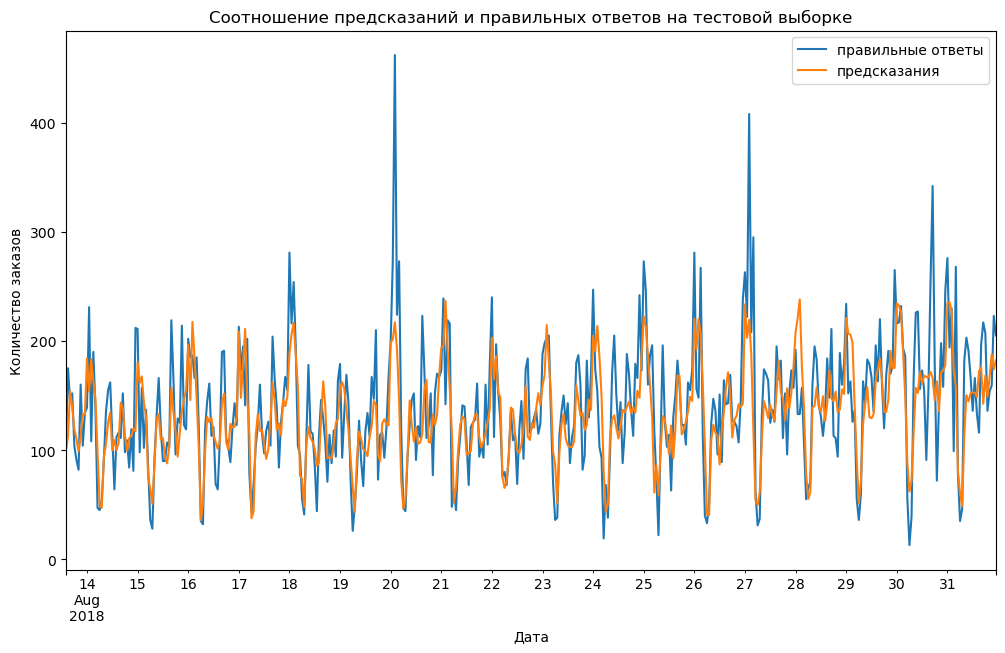

In [44]:
gbm_target_test.plot(figsize=(12,7), 
                     legend=True, 
                     label='правильные ответы');
predictions_test = pd.Series(predictions_test, index=gbm_target_test.index)
predictions_test.plot(figsize=(12,7), 
                      legend=True, 
                      label='предсказания',
                      xlabel='Дата', 
                      ylabel='Количество заказов',
                      title='Cоотношение предсказаний и правильных ответов на тестовой выборке');

График показыват, что модель в целом неплохо предсказывает, но дает существенные ошибки в предсказаниях на пиковых значениях. 

* Сравнение с результатами константной модели.

In [45]:
model_dummy = DummyRegressor()
model_dummy.fit(gbm_features_train, gbm_target_train)
predictions_test_dummy = model_dummy.predict(gbm_features_test)
mse_dummy = mean_squared_error(gbm_target_test, predictions_test_dummy)
print("Значение RMSE на константной модели =", mse_dummy ** 0.5)

Значение RMSE на константной модели = 84.6499381993622


Константная модель показывает худший результат, чем тестируемая лучшая модель. Таким образом, тестируемая модель прошла проверку на адекватность.

**Выводы по шагу 3**

Качество лучшей модели проверено на тестовой выборке. Значение метрики RMSE ниже требуемого порогового значения 48. Таким образом, модель прошла проверку. Также выполнена проверка модели на адекватность.

## Итоги

На основании собранных компанией «Чётенькое такси» данных о заказах такси в аэропортах была построена модель, позволяющая спрогнозировать количество заказов такси на следующий час. В ходе работы были выполнены следующие действия:

* данные загружены, выполнено их ресемплирование по одному часу;
* данные проанализированы: в среднем количество заказов такси с марта по август увеличилось, сезонность показала связь с интервалом в одни сутки, временной ряд проверен на стационарнсть;
* обучены модели: `DecisionTreeRegressor`, `RandomForestRegressor`, `CatBoostRegressor`, `LGBMRegressor`, `LinearRegression`, для каждой подобраны гиперпараметры и признаки для обучения;
* лучшая модель проверена на тестовой выборке размером 10% от исходных данных.

**Общий вывод**: 
Наилучший результат (метрика RMSE) показывает модель `LGBMRegressor` c гиперпараметрами: `learning_rate=0.1, max_depth=5`, `'n_estimators': 100`. Качество модели проверено на тестовой выборке. Модель проверена на адекватность.